## 파일 불러오기

In [30]:
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk
import requests
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
import numpy as np

In [3]:
sales = pd.read_csv('raw_data/sales_amt.csv')

s_work = pd.read_csv('raw_data/s_workpop.csv')
s_float = pd.read_csv('raw_data/s_floatpop.csv')
s_resid = pd.read_csv('raw_data/s_resid.csv')
s_apt = pd.read_csv('raw_data/s_apt.csv')
s_facil = pd.read_csv('raw_data/s_facil.csv')
s_store = pd.read_csv('raw_data/s_store.csv')

b_work = pd.read_csv('raw_data/b_workpop.csv')
b_float = pd.read_csv('raw_data/b_floatpop.csv')
b_resid = pd.read_csv('raw_data/b_resid.csv')
b_apt = pd.read_csv('raw_data/b_apt.csv')
b_facil = pd.read_csv('raw_data/b_facil.csv')
b_inc = pd.read_csv('raw_data/b_incNexpnd.csv')
b_store = pd.read_csv('raw_data/b_store.csv')

## 확인할 내용
- 상권배후지가 상권의 데이터를 포함하는 자료인지: 동일한 이름의 칼럼에서 상권배후지 수치가 항상 상권의 수치보다 커야 함.
- 각 테이블의 독립변수와 종속변수 간의 상관관계

In [4]:
# 종속변수와 상관관계를 확인하기 위해, sales 테이블에서 각 테이블에 붙일 종속변수 칼럼 떼어내기
y_table = sales[['year', 'quarter', 'district', 'code', 'sales_total']]

y_table_dist = y_table.groupby(by=['year', 'quarter', 'district'], as_index=False).sum()

### 아파트

#### 상권 아파트

In [5]:
s_apt.tail()

,year,quarter,district,s_apt_no_of_cmplx,surface_below_66m,surface_66m,surface_99m,surface_132m,surface_165m,price_below_100m,price_100m,price_200m,price_300m,price_400m,price_500m,price_above_600m,s_apt_avg_space,s_apt_avg_price
27933,2019,2,1001490,30,358.0,328.0,19.0,2.0,17.0,33.0,273.0,232.0,185.0,NaN,1.0,NaN,65,"163,770,517"
27934,2019,2,1001491,67,602.0,354.0,111.0,128.0,122.0,24.0,214.0,242.0,406.0,187.0,104.0,140.0,84,"369,919,205"
27935,2019,2,1001493,6,365.0,178.0,26.0,NaN,NaN,9.0,404.0,132.0,24.0,NaN,NaN,NaN,69,"144,042,180"
27936,2019,2,1001494,8,603.0,20.0,NaN,NaN,NaN,220.0,403.0,NaN,NaN,NaN,NaN,NaN,39,"103,667,956"
27937,2019,2,1001495,20,921.0,223.0,329.0,1122.0,378.0,83.0,687.0,148.0,93.0,41.0,35.0,1886.0,88,"431,622,104"


In [6]:
s_apt.isnull().sum()

year                     0
quarter                  0
district                 0
s_apt_no_of_cmplx        0
surface_below_66m      616
surface_66m           2137
surface_99m          10230
surface_132m         19102
surface_165m         22895
price_below_100m      2978
price_100m            1229
price_200m            5890
price_300m           15303
price_400m           20635
price_500m           23526
price_above_600m     24451
s_apt_avg_space          0
 s_apt_avg_price         0
dtype: int64

In [7]:
s_apt.fillna(0, inplace=True)

In [8]:
s_apt_test = pd.merge(s_apt, y_table_dist, on=['year', 'quarter', 'district'])

In [9]:
s_apt_corr = s_apt_test.corr()
corr_target_s_apt = abs(s_apt_corr['sales_total'])
relevant_features_s_apt = corr_target_s_apt[corr_target_s_apt > 0.5]
relevant_features_s_apt.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [10]:
s_apt_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
surface_132m,0.259639
price_above_600m,0.211621
surface_165m,0.186301
surface_99m,0.149081
price_500m,0.121365
s_apt_avg_space,0.102193
price_300m,0.082037
price_400m,0.079952
s_apt_no_of_cmplx,0.054401


#### 배후지 아파트

In [11]:
b_apt.tail()

,year,quarter,district,b_apt_no_of_cmplx,surface_below_66m,surface_66m,surface_99m,surface_132m,surface_165m,price_below_100m,price_100m,price_200m,price_300m,price_400m,price_500m,price_above_600m,b_apt_avg_space,b_apt_avg_price
21184,2014,2,1000338,199,1277,452,21,0,0,608,1159,8,0,0,0,0,55,112074493
21185,2014,2,1000337,376,2833,751,21,19,1,1819,1638,159,19,1,0,0,52,94394071
21186,2014,2,1000336,164,1178,519,33,1,0,694,789,265,1,0,0,0,53,105827422
21187,2014,2,1000335,226,1707,669,46,1,0,852,1103,393,121,0,0,0,55,113520798
21188,2014,2,1000334,385,3232,857,138,5,0,2263,1730,383,0,0,0,0,54,95730441


In [12]:
b_apt.isnull().sum()

year                 0
quarter              0
district             0
b_apt_no_of_cmplx    0
surface_below_66m    0
surface_66m          0
surface_99m          0
surface_132m         0
surface_165m         0
price_below_100m     0
price_100m           0
price_200m           0
price_300m           0
price_400m           0
price_500m           0
price_above_600m     0
b_apt_avg_space      0
b_apt_avg_price      0
dtype: int64

In [13]:
b_apt_test = pd.merge(b_apt, y_table_dist, on=['year', 'quarter', 'district'])

In [14]:
b_apt_corr = b_apt_test.corr()
corr_target_b_apt = abs(b_apt_corr['sales_total'])
relevant_features_b_apt = corr_target_b_apt[corr_target_b_apt > 0.5]
relevant_features_b_apt.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [15]:
b_apt_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
price_above_600m,0.275657
b_apt_avg_price,0.245959
surface_132m,0.235078
surface_165m,0.214114
price_500m,0.207285
b_apt_avg_space,0.186312
surface_99m,0.142002
price_400m,0.109592
surface_66m,0.100272


- 배후지 아파트가 상권 아파트 데이터를 포함하고 있는 것으로 추정
- 아파트 변수 중에는 설명력 있는 독립변수가 없는 것으로 판정 

### 집객시설

#### 1) 상권배후지가 상권 데이터 포함?

In [16]:
s_facil.tail()

,year,quarter,district,s_facil_total,s_facil_no_of_govn,s_facil_no_of_bank,s_facil_no_of_genhosp,s_facil_no_of_hosp,s_facil_no_of_pham,s_facil_no_of_kndgtn,s_facil_no_of_elemnt,s_facil_no_of_mid,s_facil_no_of_hign,s_facil_no_of_high,s_facil_no_of_dept,s_facil_no_of_supermkt,s_facil_no_of_theatre,s_facil_no_of_accom,s_facil_no_of_STA,s_facil_no_of_BUS
25641,2015,1,1000997,9,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25642,2015,1,1001256,46,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
25643,2015,1,1000064,13,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
25644,2015,1,1000707,10,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0
25645,2015,1,1000006,9,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,4.0


In [17]:
s_facil.fillna(0, inplace=True)

In [18]:
s_facil.isnull().sum()

year                      0
quarter                   0
district                  0
s_facil_total             0
s_facil_no_of_govn        0
s_facil_no_of_bank        0
s_facil_no_of_genhosp     0
s_facil_no_of_hosp        0
s_facil_no_of_pham        0
s_facil_no_of_kndgtn      0
s_facil_no_of_elemnt      0
s_facil_no_of_mid         0
s_facil_no_of_hign        0
s_facil_no_of_high        0
s_facil_no_of_dept        0
s_facil_no_of_supermkt    0
s_facil_no_of_theatre     0
s_facil_no_of_accom       0
s_facil_no_of_STA         0
s_facil_no_of_BUS         0
dtype: int64

In [19]:
s_facil_ls = list(s_facil.columns[3:])

In [20]:
b_facil.tail()

,year,quarter,district,b_facil_total,b_facil_no_of_govn,b_facil_no_of_bank,b_facil_no_of_gen_hosp,b_facil_no_of_hosp,b_facil_no_of_pham,b_facil_no_of_kndgtn,b_facil_no_of_elemnt,b_facil_no_of_mid,b_facil_no_of_high,b_facil_no_of_univ,b_facil_no_of_dept,b_facil_no_of_supermkt,b_facil_no_of_theatre,b_facil_no_of_accom,b_facil_no_of_STA,b_facil_no_of_BUS
18175,2015,1,1000781,111,NaN,7.0,NaN,2.0,16.0,2.0,2.0,1.0,NaN,NaN,NaN,1.0,2.0,1.0,NaN,19
18176,2015,1,1000723,60,NaN,2.0,NaN,NaN,8.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,29
18177,2015,1,1000762,37,NaN,2.0,NaN,NaN,3.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,18
18178,2015,1,1000783,93,NaN,3.0,1.0,NaN,13.0,3.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,31
18179,2015,1,1000814,54,NaN,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,NaN,1.0,11


In [21]:
b_facil.fillna(0, inplace=True)

In [22]:
b_facil.isnull().sum()

year                      0
quarter                   0
district                  0
b_facil_total             0
b_facil_no_of_govn        0
b_facil_no_of_bank        0
b_facil_no_of_gen_hosp    0
b_facil_no_of_hosp        0
b_facil_no_of_pham        0
b_facil_no_of_kndgtn      0
b_facil_no_of_elemnt      0
b_facil_no_of_mid         0
b_facil_no_of_high        0
b_facil_no_of_univ        0
b_facil_no_of_dept        0
b_facil_no_of_supermkt    0
b_facil_no_of_theatre     0
b_facil_no_of_accom       0
b_facil_no_of_STA         0
b_facil_no_of_BUS         0
dtype: int64

In [23]:
facil = pd.merge(b_facil, s_facil, on=['year', 'quarter', 'district'])
facil.tail()

,year,quarter,district,b_facil_total,b_facil_no_of_govn,b_facil_no_of_bank,b_facil_no_of_gen_hosp,b_facil_no_of_hosp,b_facil_no_of_pham,b_facil_no_of_kndgtn,...,s_facil_no_of_elemnt,s_facil_no_of_mid,s_facil_no_of_hign,s_facil_no_of_high,s_facil_no_of_dept,s_facil_no_of_supermkt,s_facil_no_of_theatre,s_facil_no_of_accom,s_facil_no_of_STA,s_facil_no_of_BUS
17643,2015,1,1000813,54,0.0,2.0,0.0,0.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
17644,2015,1,1000707,93,0.0,2.0,1.0,1.0,13.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
17645,2015,1,1000781,111,0.0,7.0,0.0,2.0,16.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17646,2015,1,1000723,60,0.0,2.0,0.0,0.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
17647,2015,1,1000783,93,0.0,3.0,1.0,0.0,13.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0


In [24]:
len(facil[facil['b_facil_total'] < facil['s_facil_total']].index)

0

In [25]:
b_facil_ls = list(b_facil.columns[3:])
s_facil_ls = list(s_facil.columns[3:])

for i in range(0, 17):
    print(i, len(facil[facil[b_facil_ls[i]] < facil[s_facil_ls[i]]].index))
# 상권 수치데이터 중에 상권배후지 수치데이터보다 큰 값을 가지는 데이터는 단 하나도 없음

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0


#### 2) 집객시설 데이터와 종속변수 상관관계 확인

In [26]:
facil_test = pd.merge(facil, y_table_dist, on=['year', 'quarter', 'district'])

In [27]:
facil_test.corr().iloc[3:,[-1]].sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
s_facil_total,0.538472
s_facil_no_of_bank,0.400231
s_facil_no_of_pham,0.398377
b_facil_no_of_bank,0.362040
b_facil_total,0.266143
b_facil_no_of_pham,0.198068
s_facil_no_of_supermkt,0.193725
b_facil_no_of_supermkt,0.180364
s_facil_no_of_STA,0.160742


In [31]:
corr_matrix_facil = facil.corr().abs()
upper = corr_matrix_facil.where(np.triu(np.ones(corr_matrix_facil.shape), k=1).astype(np.bool))

In [32]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
to_drop

['b_facil_no_of_bank',
 'b_facil_no_of_pham',
 's_facil_no_of_pham',
 's_facil_no_of_theatre',
 's_facil_no_of_accom',
 's_facil_no_of_BUS']

- 상권 배후지 데이터가 상권 데이터를 포함하고 있는 것으로 추정
- facil에서는 설명력이 제일 높은 상권 총집객시설 수 (s_facil_total)만 가져오기.

### 배후지 소득소비

In [33]:
b_inc.tail() # b_income_avg_monthly_inc, b_expnd_total만 추출해서 병합

,year,quarter,district,b_income_avg_monthly_inc,b_expnd_total,b_expnd_groceries,b_expnd_clothes,b_expnd_daily_supplies,b_expnd_med_care,b_expnd_trans,b_expnd_leisure,b_expnd_culture,b_expnd_ed,b_expnd_entmt
21205,2014,2,1000005,4808322,3148064882,793425365,386828803,234486533,408696149,543151691,123407058,91007633,431082191,135979459
21206,2014,2,1000004,3451327,4459815839,1109869127,586682272,324173793,561010218,657987418,165355483,160499636,672841452,221396440
21207,2014,2,1000003,3412262,2864546945,772486155,360274940,232788064,421569375,509106552,112506992,88103443,234613249,133098175
21208,2014,2,1000002,3959710,4369500227,1093110211,547076726,330060993,554646137,725905046,168116961,142023924,613416329,195143900
21209,2014,2,1000001,3994609,3217010985,831487324,396779700,248991779,438778489,568695592,125203778,96098541,369252645,141723137


In [34]:
b_inc_test = pd.merge(b_inc, y_table_dist, on=['year', 'quarter', 'district'])
b_inc_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
b_income_avg_monthly_inc,0.235412
b_expnd_ed,0.174100
b_expnd_leisure,0.143762
b_expnd_trans,0.116322
b_expnd_clothes,0.112014
b_expnd_daily_supplies,0.109175
b_expnd_entmt,0.105370
b_expnd_total,0.097862
b_expnd_culture,0.088275


- 배후지 소득소비에서는 종속변수에 대한 설명력 있는 변수가 없음

### 유동인구

#### 상권 유동인구

In [35]:
s_float.tail()

,year,quarter,district,s_float_male_10s_MON_time1,s_float_male_10s_MON_time2,s_float_male_10s_MON_time3,s_float_male_10s_MON_time4,s_float_male_10s_MON_time5,s_float_male_10s_MON_time6,s_float_male_10s_TUE_time1,...,s_float_female_60s_SAT_time3,s_float_female_60s_SAT_time4,s_float_female_60s_SAT_time5,s_float_female_60s_SAT_time6,s_float_female_60s_SUN_time1,s_float_female_60s_SUN_time2,s_float_female_60s_SUN_time3,s_float_female_60s_SUN_time4,s_float_female_60s_SUN_time5,s_float_female_60s_SUN_time6
32803,2019,2,1001492,94,411,857,1062,1296,353,81,...,17327,19071,9724,1088,594,3285,8034,8473,5338,639
32804,2019,2,1001493,386,1342,1509,1540,1014,374,381,...,5726,5746,3788,1379,1954,2847,3526,3673,3333,2652
32805,2019,2,1001494,377,551,1293,1807,3144,898,236,...,10844,11381,9491,2312,1550,3417,6554,6862,5344,1506
32806,2019,2,1001495,827,572,565,723,1435,774,646,...,3880,3936,4813,1985,2668,2921,3662,3345,3635,1530
32807,2019,2,1001496,3,8,25,36,40,9,0,...,115,117,102,23,23,59,106,100,73,17


In [36]:
s_float_test = pd.merge(s_float, y_table_dist, on=['year', 'quarter', 'district'])

In [37]:
s_float_corr = s_float_test.corr()
corr_target_s_float = abs(s_float_corr['sales_total'])
relevant_features_s_float = corr_target_s_float[corr_target_s_float > 0.7]
relevant_features_s_float

s_float_male_20s_MON_time3      0.702738
s_float_male_20s_MON_time4      0.719559
s_float_male_20s_TUE_time3      0.707297
s_float_male_20s_TUE_time4      0.725830
s_float_male_20s_WED_time3      0.705643
                                  ...   
s_float_female_60s_THU_time3    0.711571
s_float_female_60s_THU_time4    0.706136
s_float_female_60s_FRI_time3    0.707855
s_float_female_60s_FRI_time4    0.701357
sales_total                     1.000000
Name: sales_total, Length: 155, dtype: float64

In [38]:
# 상관관계 0.7이 넘은 154개의 변수 중, 성별에 따른 변수 갯수 분포
sex_ls = ['s_float_male', 's_float_female']
[relevant_features_s_float.sort_values(ascending=False).index.str.contains(i).sum() for i in sex_ls]

[69, 85]

In [39]:
# 상관관계 0.7이 넘은 154개의 변수 중, 연령대에 따른 변수 갯수 분포
[relevant_features_s_float.sort_values(ascending=False).index.str.contains(str(i)+'s').sum() for i in range(10, 70, 10)]

[0, 24, 62, 47, 12, 9]

In [40]:
# 상관관계 0.7이 넘은 154개의 변수 중, 요일별 변수 갯수 분포
days_ls = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
[relevant_features_s_float.sort_values(ascending=False).index.str.contains(i).sum() for i in days_ls]

[24, 26, 27, 27, 27, 14, 9]

In [41]:
# 상관관계 0.7이 넘은 154개의 변수 중, 6개의 시간대에 따른 변수 갯수 분포
[relevant_features_s_float.sort_values(ascending=False).index.str.contains('time'+str(i)).sum() for i in range(1, 7)]

[0, 15, 48, 46, 30, 15]

위 자료를 근거로 **최초 변수 선택의 근거**로 삼고, **분포를 bar-chart로** 보여주면 좋을 듯

In [42]:
# 종속변수와의 상관관계가 높은 변수들 중, 변수들 간의 선형종속에 가까운 변수 필터링
corr_list_s_float = list(corr_target_s_float[corr_target_s_float > 0.7].index)
corr_matrix_s_float = s_float_test[corr_list_s_float].corr().abs()
upper = corr_matrix_s_float.where(np.triu(np.ones(corr_matrix_s_float.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
to_drop

# corr_matrix_s_float = s_float_test[corr_list_s_float].corr().abs()
# upper = corr_matrix_s_float.where(np.triu(np.ones(corr_matrix_s_float.shape), k=1).astype(np.bool))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
# to_drop

['s_float_male_20s_MON_time4',
 's_float_male_20s_TUE_time3',
 's_float_male_20s_TUE_time4',
 's_float_male_20s_WED_time3',
 's_float_male_20s_WED_time4',
 's_float_male_20s_THU_time3',
 's_float_male_20s_THU_time4',
 's_float_male_20s_FRI_time3',
 's_float_male_20s_FRI_time4',
 's_float_male_30s_MON_time2',
 's_float_male_30s_MON_time3',
 's_float_male_30s_MON_time4',
 's_float_male_30s_MON_time5',
 's_float_male_30s_MON_time6',
 's_float_male_30s_TUE_time2',
 's_float_male_30s_TUE_time3',
 's_float_male_30s_TUE_time4',
 's_float_male_30s_TUE_time5',
 's_float_male_30s_TUE_time6',
 's_float_male_30s_WED_time2',
 's_float_male_30s_WED_time3',
 's_float_male_30s_WED_time4',
 's_float_male_30s_WED_time5',
 's_float_male_30s_WED_time6',
 's_float_male_30s_THU_time2',
 's_float_male_30s_THU_time3',
 's_float_male_30s_THU_time4',
 's_float_male_30s_THU_time5',
 's_float_male_30s_THU_time6',
 's_float_male_30s_FRI_time2',
 's_float_male_30s_FRI_time3',
 's_float_male_30s_FRI_time4',
 's_floa

In [43]:
len(to_drop)

154

- 상권 유동인구에서 매출과 상관관계를 알려주는 변수들이 많음
- 다만 상호 종속의 관계가 강한 변수들이 많기에, 변수들 중 일부만 선택하거나 변수를 합치거나 혹은 변형하는 과정이 필요

#### 배후지 유동인구

In [44]:
b_float.tail()

,year,quarter,district,b_float_male_10s_MON_time1,b_float_male_10s_MON_time2,b_float_male_10s_MON_time3,b_float_male_10s_MON_time4,b_float_male_10s_MON_time5,b_float_male_10s_MON_time6,b_float_male_10s_TUE_time1,...,b_float_female_60s_SAT_time3,b_float_female_60s_SAT_time4,b_float_female_60s_SAT_time5,b_float_female_60s_SAT_time6,b_float_female_60s_SUN_time1,b_float_female_60s_SUN_time2,b_float_female_60s_SUN_time3,b_float_female_60s_SUN_time4,b_float_female_60s_SUN_time5,b_float_female_60s_SUN_time6
22215,2019,2,1001006,1765,1287,738,1347,2518,1234,1653,...,4088,3988,4756,2446,4222,5339,5043,4025,4952,2368
22216,2019,2,1001007,22,460,521,434,175,12,23,...,399,358,344,96,129,380,436,335,228,61
22217,2019,2,1001008,1391,610,671,1408,3287,1701,1145,...,9679,10857,11518,4367,6371,9230,10909,10057,10955,3682
22218,2019,2,1001009,1408,901,781,1617,3280,1678,1282,...,8636,8576,10168,4812,7419,10889,10987,8194,10057,4140
22219,2019,2,1001010,1565,1284,956,1571,2854,1447,1385,...,6181,5944,7213,3913,6276,7195,6096,5594,6503,3462


In [45]:
b_float_test = pd.merge(b_float, y_table_dist, on=['year', 'quarter', 'district'])
b_float_corr = b_float_test.corr()
corr_target_b_float = abs(b_float_corr['sales_total'])
relevant_features_b_float = corr_target_b_float[corr_target_b_float > 0.5]
relevant_features_b_float.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [46]:
b_float_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
b_float_male_30s_THU_time6,0.225128
b_float_male_40s_THU_time6,0.223443
b_float_male_40s_TUE_time6,0.218694
b_float_male_30s_TUE_time6,0.217726
...,...
b_float_male_60s_MON_time1,0.033313
b_float_male_60s_SUN_time1,0.033006
b_float_female_60s_SUN_time2,0.028469
b_float_female_60s_MON_time1,0.028108


- 배후지 유동인구에서는 종속변수에 대한 설명력 있는 변수가 없음

### 직장인구

#### 상권 직장인구

In [47]:
s_work.tail()

,year,quarter,district,s_work_male_10s,s_work_male_20s,s_work_male_30s,s_work_male_40s,s_work_male_50s,s_work_male_60s,s_work_female_10s,s_work_female_20s,s_work_female_30s,s_work_female_40s,s_work_female_50s,s_work_female_60s
28308,2014,2,1000006,0,0,2,0,1,4,0,3,3,2,2,0
28309,2014,2,1000005,0,2,13,14,12,10,0,6,12,10,6,6
28310,2014,2,1000004,0,0,2,2,0,1,0,0,1,0,1,0
28311,2014,2,1000003,0,42,144,149,120,109,1,79,154,95,83,52
28312,2014,2,1000001,3,45,102,112,82,34,1,111,146,78,51,12


In [48]:
s_work_test = pd.merge(s_work, y_table_dist, on=['year', 'quarter', 'district'])

In [49]:
s_work_corr = s_work_test.corr()
corr_target_s_work = abs(s_work_corr['sales_total'])
relevant_features_s_work = corr_target_s_work[corr_target_s_work > 0.5]
relevant_features_s_work.sort_values(ascending=False)

sales_total          1.000000
s_work_female_20s    0.637839
s_work_female_30s    0.632814
s_work_female_40s    0.601936
s_work_male_50s      0.594365
s_work_male_60s      0.550934
s_work_female_50s    0.537814
s_work_male_40s      0.533774
s_work_female_60s    0.518462
s_work_male_20s      0.506438
Name: sales_total, dtype: float64

In [50]:
# 종속변수와의 상관관계가 높은 변수들 중, 변수들 간의 선형종속에 가까운 변수 필터링
corr_list_s_work = list(corr_target_s_work[corr_target_s_work > 0.5].index)
corr_matrix_s_work = s_work_test[corr_list_s_work].corr().abs()
upper = corr_matrix_s_work.where(np.triu(np.ones(corr_matrix_s_work.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
to_drop

['s_work_male_40s',
 's_work_male_50s',
 's_work_male_60s',
 's_work_female_20s',
 's_work_female_30s',
 's_work_female_40s',
 's_work_female_50s',
 's_work_female_60s',
 'sales_total']

- 상권 직장인구도 상권 유동인구 테이블과 마찬가지로, 종속변수에 대해 설명력 있는 변수들이 많음.
- 상권 유동인구 테이블과 마찬가지로 다중공선성 문제 존재. 변수들 중 일부만 선택하거나 변수를 합치거나 혹은 변형하는 과정이 필요.
- 상권 유동인구 테이블에서는 여성 총합으로 산출한 변형변수 하나를 추출하는 방법이 제일 좋을 듯.

#### 배후지 직장인구

In [51]:
b_work.tail()

,year,quarter,district,b_work_male_10s,b_work_male_20s,b_work_male_30s,b_work_male_40s,b_work_male_50s,b_work_male_60s,b_work_female_10s,b_work_female_20s,b_work_female_30s,b_work_female_40s,b_work_female_50s,b_work_female_60s
21205,2014,2,1000005,1,112,311,314,129,67,1,237,211,156,93,30
21206,2014,2,1000004,3,276,1188,1301,1025,450,3,594,856,571,359,182
21207,2014,2,1000003,28,3216,10492,9316,4941,2106,53,3973,4801,2309,1391,937
21208,2014,2,1000002,18,424,1106,1171,1230,1279,48,680,775,708,992,676
21209,2014,2,1000001,11,1435,5285,4845,2581,891,9,1287,2107,1120,652,323


In [52]:
b_work_test = pd.merge(b_work, y_table_dist, on=['year', 'quarter', 'district'])
b_work_corr = b_work_test.corr()
corr_target_b_work = abs(b_work_corr['sales_total'])
relevant_features_b_work = corr_target_b_work[corr_target_b_work > 0.5]
relevant_features_b_work.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [53]:
b_work_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
b_work_male_60s,0.248433
b_work_female_20s,0.246956
b_work_male_30s,0.246148
b_work_female_30s,0.241084
b_work_male_20s,0.232375
b_work_male_40s,0.231002
b_work_female_40s,0.215218
b_work_male_50s,0.190788
b_work_female_60s,0.188547


- 배후지 직장인구에서는 종속변수에 대한 설명력 있는 변수가 없음

### 상주인구

#### 상권 상주인구

In [54]:
s_resid.tail()

,year,quarter,district,s_resid_male_10s,s_resid_male_20s,s_resid_male_30s,s_resid_male_40s,s_resid_male_50s,s_resid_male_60s,s_resid_female_10s,s_resid_female_20s,s_resid_female_30s,s_resid_female_40s,s_resid_female_50s,s_resid_female_60s,s_resid_no_of_apt_fam,s_resid_no_of_nonapt_fam
30924,2014,2,1000005,72,69,41,80,69,17,36,44,36,102,77,37,0,0
30925,2014,2,1000004,13,185,96,45,22,5,12,168,51,65,42,11,0,0
30926,2014,2,1000003,21,43,65,91,123,120,23,36,37,37,75,90,0,0
30927,2014,2,1000002,36,44,51,52,51,56,27,45,45,40,45,61,0,0
30928,2014,2,1000001,20,17,21,36,19,20,17,18,35,36,23,32,0,0


In [55]:
s_resid_test = pd.merge(s_resid, y_table_dist, on=['year', 'quarter', 'district'])
s_resid_corr = s_resid_test.corr()
corr_target_s_resid = abs(s_resid_corr['sales_total'])
relevant_features_s_resid = corr_target_s_resid[corr_target_s_resid > 0.5]
relevant_features_s_resid.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [56]:
s_resid_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
s_resid_female_20s,0.072686
s_resid_female_30s,0.072096
s_resid_no_of_apt_fam,0.051681
s_resid_female_50s,0.041536
s_resid_male_10s,0.038212
s_resid_no_of_nonapt_fam,0.037377
s_resid_female_10s,0.032402
s_resid_male_30s,0.031603
s_resid_male_50s,0.023243


#### 배후지 상주인구

In [57]:
b_resid.tail()

,year,quarter,district,b_resid_male_10s,b_resid_male_20s,b_resid_male_30s,b_resid_male_40s,b_resid_male_50s,b_resid_male_60s,b_resid_female_10s,b_resid_female_20s,b_resid_female_30s,b_resid_female_40s,b_resid_female_50s,b_resid_female_60s,b_resid_no_of_apt_fam,b_resid_no_of_nonapt_fam
21205,2014,2,1000005,270,222,180,269,228,122,177,177,162,325,260,207,0,0
21206,2014,2,1000004,86,1196,623,303,149,54,76,1061,324,416,255,99,0,0
21207,2014,2,1000003,32,74,122,169,307,207,33,61,65,65,149,153,0,0
21208,2014,2,1000002,402,512,689,635,593,544,351,502,607,491,540,607,0,0
21209,2014,2,1000001,99,93,127,169,109,79,62,116,167,169,137,165,0,0


In [58]:
b_resid_test = pd.merge(b_resid, y_table_dist, on=['year', 'quarter', 'district'])
b_resid_corr = b_resid_test.corr()
corr_target_b_resid = abs(b_resid_corr['sales_total'])
relevant_features_b_resid = corr_target_b_resid[corr_target_b_resid > 0.5]
relevant_features_b_resid.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

In [59]:
b_resid_test.corr().iloc[3:,[-1]].abs().sort_values(by='sales_total', ascending=False)

,sales_total
sales_total,1.000000
b_resid_female_30s,0.110111
b_resid_no_of_apt_fam,0.098356
b_resid_female_20s,0.095960
b_resid_male_10s,0.080690
b_resid_female_10s,0.077571
b_resid_female_40s,0.055950
b_resid_female_60s,0.046263
b_resid_male_20s,0.043496
b_resid_male_30s,0.041894


- 상주인구 테이블에서는 상권, 배후지 모두 종속변수에 대한 설명력 있는 변수가 없음

### 점포

#### 상권 점포

In [60]:
s_store.tail()

,year,quarter,district,code,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_store_no_of_fran
1252897,2014,1,1000001,CS100005,3,0,1,2
1252898,2014,1,1000001,CS100004,7,0,0,1
1252899,2014,1,1000001,CS100003,2,0,0,0
1252900,2014,1,1000001,CS100002,2,0,0,0
1252901,2014,1,1000001,CS100001,15,0,0,0


In [61]:
s_store_test = pd.merge(s_store, y_table, on=['year', 'quarter', 'district', 'code'])
s_store_test.tail()

,year,quarter,district,code,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_store_no_of_fran,sales_total
767265,2014,1,1000001,CS100005,3,0,1,2,174593368.0
767266,2014,1,1000001,CS100004,7,0,0,1,193600037.0
767267,2014,1,1000001,CS100003,2,0,0,0,37714297.0
767268,2014,1,1000001,CS100002,2,0,0,0,164087954.0
767269,2014,1,1000001,CS100001,15,0,0,0,644598233.0


In [62]:
s_store_corr = s_store_test.corr()
corr_target_s_store = abs(s_store_corr['sales_total'])
relevant_features_s_store = corr_target_s_store[corr_target_s_store > 0.5]
relevant_features_s_store.sort_values(ascending=False)

sales_total              1.000000
s_store_no_of_store      0.731850
s_store_no_of_closing    0.653734
s_store_no_of_opening    0.615017
Name: sales_total, dtype: float64

In [63]:
# 종속변수와의 상관관계가 높은 변수들 중, 변수들 간의 선형종속에 가까운 변수 필터링
corr_list_s_store = list(corr_target_s_store[corr_target_s_store > 0.5].index)
corr_matrix_s_store = s_store_test[corr_list_s_store].corr().abs()
upper = corr_matrix_s_store.where(np.triu(np.ones(corr_matrix_s_store.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
to_drop

['s_store_no_of_opening', 's_store_no_of_closing', 'sales_total']

In [64]:
s_store_test[corr_list_s_store].corr()

,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,sales_total
s_store_no_of_store,1.000000,0.727766,0.851444,0.731850
s_store_no_of_opening,0.727766,1.000000,0.731352,0.615017
s_store_no_of_closing,0.851444,0.731352,1.000000,0.653734
sales_total,0.731850,0.615017,0.653734,1.000000


- 상권 점포 테이블에서도 프랜차이즈 점포수를 제외한 모든 변수가 설명력이 있는 것으로 나타남
- 선형종속에 가까운 독립변수들이지만, 개인적으로는 PCA를 사용하여 남겨보고 싶음

#### 배후지 점포

In [65]:
b_store.tail()

,year,quarter,district,code,b_store_no_of_store,b_store_no_of_opening,b_store_no_of_closing,b_store_no_of_fran
995508,2014,1,1000001,CS100005,15,1,1,5
995509,2014,1,1000001,CS100004,28,1,0,4
995510,2014,1,1000001,CS100003,5,0,0,2
995511,2014,1,1000001,CS100002,7,0,1,0
995512,2014,1,1000001,CS100001,113,6,5,5


In [66]:
b_store_test = pd.merge(b_store, y_table, on=['year', 'quarter', 'district', 'code'])
b_store_test.tail()

,year,quarter,district,code,b_store_no_of_store,b_store_no_of_opening,b_store_no_of_closing,b_store_no_of_fran,sales_total
510897,2014,1,1000001,CS100005,15,1,1,5,174593368.0
510898,2014,1,1000001,CS100004,28,1,0,4,193600037.0
510899,2014,1,1000001,CS100003,5,0,0,2,37714297.0
510900,2014,1,1000001,CS100002,7,0,1,0,164087954.0
510901,2014,1,1000001,CS100001,113,6,5,5,644598233.0


In [67]:
b_store_corr = b_store_test.corr()
corr_target_b_store = abs(b_store_corr['sales_total'])
relevant_features_b_store = corr_target_b_store[corr_target_b_store > 0.5]
relevant_features_b_store.sort_values(ascending=False)

sales_total    1.0
Name: sales_total, dtype: float64

- 배후지 점포 테이블에서는 설명력 있는 변수가 없음

### 상권 매출

In [68]:
sales.tail()

,year,quarter,district,code,sales_weekday_amt,sales_female_amt,sales_2030s_amt,sales_06_11_amt,sales_11_14_amt,sales_14_17_amt,sales_17_21_amt,sales_21_24_amt,sales_total
911222,2013,1,1001332,CS300004,50032218.0,52489413.0,35073041.0,0.0,17488492.0,23088462.0,14606926.0,6813185.0,61997065.0
911223,2013,1,1001016,CS300004,107443834.0,48157351.0,114105417.0,5564566.0,27981822.0,47839378.0,60860461.0,0.0,142246227.0
911224,2013,1,1001228,CS300007,13545533.0,2832364.0,1380127.0,0.0,3834298.0,8771734.0,2781322.0,0.0,15387354.0
911225,2013,1,1001232,CS300004,30507083.0,15528562.0,2161977.0,0.0,20710223.0,8059043.0,1737817.0,0.0,30507083.0
911226,2013,1,1000407,CS300004,4190966.0,0.0,0.0,0.0,4190966.0,0.0,0.0,0.0,4190966.0


In [69]:
sales_corr = sales.corr()
corr_target_sales = abs(sales_corr['sales_total'])
relevant_features_sales = corr_target_sales[corr_target_sales > 0.5]
relevant_features_sales.sort_values(ascending=False)

sales_total          1.000000
sales_weekday_amt    0.987595
sales_17_21_amt      0.963676
sales_female_amt     0.940768
sales_2030s_amt      0.939437
sales_14_17_amt      0.904552
sales_11_14_amt      0.904087
sales_21_24_amt      0.775360
sales_06_11_amt      0.538336
Name: sales_total, dtype: float64

- 상권 매출은 위와 같은 변수들이 설명력을 가지고 있음.
- 그러나 과연 총매출을 예측하는데 총매출을 구성하는 일부 매출들을 독립변수로 사용하는 것이 적절한 것인지 의문.

## Merging Tables
- 배후지 집객시설: b_facil_total
- 상권 유동인구: 일단 모든 컬럼 붙이기
- 상권 직장인구: 여성 모든 컬럼 가져와서 붙이고, 여성 총 직장인구 산출하기
- 상권 점포: s_store_no_of_store, s_store_no_of_opening, s_store_no_of_closing
- 매출: 일단 모든 컬럼 붙이기

In [70]:
# 상권 직장인구
s_work_ls = ['year', 'quarter', 'district'] + \
    list(s_work.columns[s_work.columns.str.contains('female')]) # 가장 설명력이 좋았던 여성 변수들만 추출
s_work_ls.remove('s_work_female_10s') # 그 중 여성 10대는 종속변수와 상관관계 0.5 미만이므로 삭제
s_work_merge = s_work[s_work_ls]

In [71]:
# 상권 유동인구
s_float_ls = ['year', 'quarter', 'district'] + \
    list(relevant_features_s_float.index) # 종속변수와 상관관계 0.7 이상이었던 154개의 변수들만 추출

# 그 중 상관관계 분석을 위해 merge했던 종속변수 컬럼을, 후에 merge할 sales 테이블과 중복되지 않게 제거
s_float_ls.remove('sales_total')
s_float_merge = s_float[s_float_ls]

In [72]:
# 집객시설
facil_merge = facil[['year', 'quarter', 'district', 'b_facil_total']]
# 상권 점포
s_store_merge = s_store[['year', 'quarter', 'district', 'code', 's_store_no_of_store', 's_store_no_of_opening', 's_store_no_of_closing']]

In [73]:
# 상권 코드까지만 있는 테이블끼리 묶기: 상권코드라는 범주형 데이터의 카테고리 임베딩
from functools import reduce
merge_ls = [s_float_merge, s_work_merge, facil_merge]
df1 = reduce(lambda left, right: pd.merge(
    left, right, on=['year', 'quarter', 'district']), merge_ls)

# 업종 코드 있는 테이블끼리 묶기
df2 = pd.merge(s_store_merge, sales, on=['year', 'quarter', 'district', 'code'])

In [74]:
df1.tail() # df2와 merging 후, district 컬럼을 삭제함으로써, 카테고리 임베딩

,year,quarter,district,s_float_male_20s_MON_time3,s_float_male_20s_MON_time4,s_float_male_20s_TUE_time3,s_float_male_20s_TUE_time4,s_float_male_20s_WED_time3,s_float_male_20s_WED_time4,s_float_male_20s_THU_time3,...,s_float_female_60s_THU_time3,s_float_female_60s_THU_time4,s_float_female_60s_FRI_time3,s_float_female_60s_FRI_time4,s_work_female_20s,s_work_female_30s,s_work_female_40s,s_work_female_50s,s_work_female_60s,b_facil_total
17062,2019,2,1001006,383,369,320,338,329,346,335,...,753,669,692,709,11,18,42,32,19,96
17063,2019,2,1001007,117,105,113,98,104,92,110,...,133,114,184,182,22,43,49,116,330,48
17064,2019,2,1001008,698,932,656,851,692,884,667,...,907,967,925,949,25,19,14,23,17,197
17065,2019,2,1001009,1181,1149,1153,1149,1076,1115,1106,...,1588,1622,1860,1637,72,52,46,65,28,158
17066,2019,2,1001010,286,258,246,245,258,239,265,...,541,558,578,541,27,46,45,47,45,93


In [75]:
df2.tail()

,year,quarter,district,code,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,sales_weekday_amt,sales_female_amt,sales_2030s_amt,sales_06_11_amt,sales_11_14_amt,sales_14_17_amt,sales_17_21_amt,sales_21_24_amt,sales_total
767265,2014,1,1000001,CS100005,3,0,1,125943545.0,80599768.0,96490932.0,714589.0,77934304.0,48676967.0,47104228.0,163280.0,174593368.0
767266,2014,1,1000001,CS100004,7,0,0,128569822.0,73906892.0,95876401.0,545300.0,73257213.0,40992823.0,67978619.0,10826082.0,193600037.0
767267,2014,1,1000001,CS100003,2,0,0,34859711.0,12431520.0,17692526.0,0.0,19695205.0,1469032.0,8448795.0,7705307.0,37714297.0
767268,2014,1,1000001,CS100002,2,0,0,128173866.0,37693488.0,65912874.0,7001557.0,74678682.0,22714882.0,59082790.0,610043.0,164087954.0
767269,2014,1,1000001,CS100001,15,0,0,473762559.0,169581171.0,200051427.0,4409130.0,237624611.0,92338803.0,203277860.0,83957302.0,644598233.0


In [76]:
#df1과 df2 merge
df = pd.merge(df2, df1, on=['year', 'quarter', 'district'])

In [77]:
df.drop(columns='district', inplace=True) #상권코드라는 범주형 데이터가 임베딩 되었으니 범주형 컬럼은 삭제

In [78]:
df.tail()

,year,quarter,code,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,sales_weekday_amt,sales_female_amt,sales_2030s_amt,sales_06_11_amt,...,s_float_female_60s_THU_time3,s_float_female_60s_THU_time4,s_float_female_60s_FRI_time3,s_float_female_60s_FRI_time4,s_work_female_20s,s_work_female_30s,s_work_female_40s,s_work_female_50s,s_work_female_60s,b_facil_total
393794,2015,1,CS100005,3,1,1,121838057.0,76152767.0,88366350.0,1773861.0,...,122,129,62,71,120,147,84,49,11,129
393795,2015,1,CS100004,5,0,1,235780475.0,144797949.0,183620598.0,439205.0,...,122,129,62,71,120,147,84,49,11,129
393796,2015,1,CS100003,2,0,0,36791545.0,12146427.0,19139306.0,0.0,...,122,129,62,71,120,147,84,49,11,129
393797,2015,1,CS100002,2,0,0,134095298.0,59356340.0,83893487.0,585171.0,...,122,129,62,71,120,147,84,49,11,129
393798,2015,1,CS100001,16,0,0,531231665.0,221546803.0,243250096.0,7168661.0,...,122,129,62,71,120,147,84,49,11,129


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393799 entries, 0 to 393798
Columns: 175 entries, year to b_facil_total
dtypes: float64(9), int64(165), object(1)
memory usage: 528.8+ MB


In [80]:
# # df 저장
# df.to_csv('raw_data/df.csv', index=False, encoding='utf-8')

## #TODO
- 분기 컬럼을 없애면서, 수치형 데이터를 sum()을 할지 혹은 mean()을 할지 의사결정
- 연도, 업종코드를 제외한 173개의 독립변수를 설명력은 최대한 유지하면서 어떻게 줄일지 의사결정 (단순제거 or 합산 or 변형)
- Regression 결과를 확인하고, 변수 Tuning의 연속
- Visualization

### s_float_pop 변수 만들기

In [217]:
s_float_pop = pd.read_csv('raw_data/s_floatPop.csv', encoding = 'euc-kr')

In [218]:
# 조건에 맞는 컬럼명만 골라내기
s_float_male_col=s_float_pop.columns[3:255]
s_float_female_col= s_float_pop.columns[256:]
s_float_20s = []
s_float_30s = []
s_float_40s = []

for i in s_float_pop.columns:
    if "20s" in i:
        s_float_20s.append(i)
        
    elif "30s" in i:
        s_float_30s.append(i)
        
    elif "40s" in i:
        s_float_40s.append(i)
        


In [219]:
# 각 행마다 sum하고, s_float_pop에 새 컬럼 추가하기
s_float_pop['s_float_male'] = s_float_pop[s_float_pop.columns[3:255]].T.sum()
s_float_pop['s_float_female'] = s_float_pop[s_float_female_col].T.sum()
s_float_pop['s_float_20s'] = s_float_pop[s_float_20s].T.sum()
s_float_pop['s_float_30s'] = s_float_pop[s_float_30s].T.sum()
s_float_pop['s_float_40s'] = s_float_pop[s_float_40s].T.sum()

In [220]:
s_float_pops=pd.concat([s_float_pop[s_float_pop.columns[:3]],s_float_pop[s_float_pop.columns[-5:]]], axis=1)
s_float_pops.tail()

,year,quarter,district,s_float_male,s_float_female,s_float_20s,s_float_30s,s_float_40s
32803,2019,2,1001492,2729662,2945062,1447895,1486330,1087879
32804,2019,2,1001493,1614075,1639255,869536,843611,542117
32805,2019,2,1001494,2691302,2256638,1480884,1041443,773449
32806,2019,2,1001495,1246797,1168991,744939,583626,386038
32807,2019,2,1001496,39455,39951,24423,22823,14517


In [221]:
# # df 저장
# s_float_pops.to_csv('raw_data/s_float_pops.csv', index=False, encoding='utf-8')

In [222]:
#district 있는 df에 merge
df_before_emb = pd.read_csv('raw_data/df_before_emb.csv')
# s_float_pops = pd.read_csv('raw_data/s_float_pops.csv')

In [223]:
df_added=pd.merge(df_before_emb,s_float_pops,on=['year', 'quarter', 'district'] )

#### Swork 남성 여성 구하기

In [224]:
s_work = pd.read_csv('raw_data/s_workpop.csv')

In [225]:
# 남성, 여성 컬럼만 골라내기
s_work_male = s_work.columns[3:9]
s_work_female = s_work.columns[9:]


In [226]:
s_work['s_work_male']=s_work[s_work_male].T.sum()
s_work['s_work_female'] = s_work[s_work_female].T.sum()


In [227]:
s_works=s_work[['year', 'quarter', 'district','s_work_female', 's_work_male']]
s_works.tail(1)

,year,quarter,district,s_work_female,s_work_male
28312,2014,2,1000001,399,378


In [228]:
#district 있는 df에 merge

df_added=pd.merge(df_added,s_works,on=['year', 'quarter', 'district'] )

In [229]:
s_columns=['s_work_female',
 's_work_male',
's_float_male',
 's_float_female',
"b_facil_total"
]


In [230]:
df_result=pd.concat([df_added[df_added.columns[:16]],df_added[s_columns]],axis=1)

df_result.columns

Index(['year', 'quarter', 'district', 'code', 's_store_no_of_store',
       's_store_no_of_opening', 's_store_no_of_closing', 'sales_weekday_amt',
       'sales_female_amt', 'sales_2030s_amt', 'sales_06_11_amt',
       'sales_11_14_amt', 'sales_14_17_amt', 'sales_17_21_amt',
       'sales_21_24_amt', 'sales_total', 's_work_female', 's_work_male',
       's_float_male', 's_float_female', 'b_facil_total'],
      dtype='object')

### 배후지 아파트 평균 분양가격 추가(매출액과 상관관계 0.245)

In [231]:
b_apt = pd.read_csv('raw_data/b_apt.csv', encoding='euc-kr')
b_apt= b_apt[['year', 'quarter', 'district', 'b_apt_avg_price']]
df_result=pd.merge(df_result, b_apt, on=['year','quarter','district'])

### 배후지의 월 평균 소득 추가 (매출액과 상관관계 :0.235412)

In [232]:
b_inc = pd.read_csv('raw_data/b_incNexpnd.csv')
df_result=pd.merge(df_result, b_inc[['year', 'quarter', 'district', 'b_income_avg_monthly_inc']], on=['year','quarter','district'])
df_result.columns

Index(['year', 'quarter', 'district', 'code', 's_store_no_of_store',
       's_store_no_of_opening', 's_store_no_of_closing', 'sales_weekday_amt',
       'sales_female_amt', 'sales_2030s_amt', 'sales_06_11_amt',
       'sales_11_14_amt', 'sales_14_17_amt', 'sales_17_21_amt',
       'sales_21_24_amt', 'sales_total', 's_work_female', 's_work_male',
       's_float_male', 's_float_female', 'b_facil_total', 'b_apt_avg_price',
       'b_income_avg_monthly_inc'],
      dtype='object')

In [233]:
# df 저장
df_result.to_csv('raw_data/df_before_groupby.csv', index=False, encoding='utf-8')

### groupby 

In [234]:
#표로 나타내기 쉽게 컬럼 순서 변경
df_result=df_result[['year', 'quarter', 'district', 'code', 'sales_total','s_store_no_of_store',
       's_store_no_of_opening', 's_store_no_of_closing', 'sales_weekday_amt',
       'sales_female_amt', 'sales_2030s_amt', 'sales_06_11_amt',
       'sales_11_14_amt', 'sales_14_17_amt', 'sales_17_21_amt',
       'sales_21_24_amt',  's_work_female', 
       's_float_male', 's_float_female', "b_facil_total",'b_apt_avg_price',
       'b_income_avg_monthly_inc']]

In [235]:
df_grouped = df_result.groupby(['year','district','code']).agg({
'sales_total' : 'sum',
's_store_no_of_store' : 'median',
's_store_no_of_opening' : 'sum',
's_store_no_of_closing' : 'sum',
'sales_weekday_amt' : 'sum',
'sales_female_amt' : 'sum',
'sales_2030s_amt' : 'sum',
'sales_06_11_amt' : 'sum',
'sales_11_14_amt' : 'sum',
'sales_14_17_amt' : 'sum',
'sales_17_21_amt' : 'sum',
'sales_21_24_amt' : 'sum',
's_work_female' : 'sum',
's_float_male' : 'sum',
's_float_female' : 'sum',
'b_facil_total' : "median",
'b_apt_avg_price' : 'median',
'b_income_avg_monthly_inc' : 'median',
})

In [236]:
df_grouped.columns

Index(['sales_total', 's_store_no_of_store', 's_store_no_of_opening',
       's_store_no_of_closing', 'sales_weekday_amt', 'sales_female_amt',
       'sales_2030s_amt', 'sales_06_11_amt', 'sales_11_14_amt',
       'sales_14_17_amt', 'sales_17_21_amt', 'sales_21_24_amt',
       's_work_female', 's_float_male', 's_float_female', 'b_facil_total',
       'b_apt_avg_price', 'b_income_avg_monthly_inc'],
      dtype='object')

In [44]:
# df 저장
# #index에 names=['year', 'quarter', 'district', 'code']가 들어있다
# df_grouped.to_csv('raw_data/df_grouped.csv', index=True, encoding='utf-8')


In [237]:
#비율로 바꾸기
df_grouped['sales_weekday']= df_grouped['sales_weekday_amt']/df_grouped['sales_total']
df_grouped['sales_female']= df_grouped['sales_female_amt']/df_grouped['sales_total']
df_grouped['sales_2030s']= df_grouped['sales_2030s_amt']/df_grouped['sales_total']
df_grouped['sales_06_11']= df_grouped['sales_06_11_amt']/df_grouped['sales_total']
df_grouped['sales_11_14']= df_grouped['sales_11_14_amt']/df_grouped['sales_total']
df_grouped['sales_14_17']= df_grouped['sales_14_17_amt']/df_grouped['sales_total']
df_grouped['sales_17_21']= df_grouped['sales_17_21_amt']/df_grouped['sales_total']
df_grouped['sales_21_24']= df_grouped['sales_21_24_amt']/df_grouped['sales_total']


In [238]:
df_grouped.drop(columns=['sales_weekday_amt', 'sales_female_amt',
       'sales_2030s_amt', 'sales_06_11_amt', 'sales_11_14_amt',
       'sales_14_17_amt', 'sales_17_21_amt', 'sales_21_24_amt'], inplace=True)

In [239]:
# df 저장
#index에 names=['year', 'quarter', 'district', 'code']가 들어있다
# df_grouped.to_csv('raw_data/df_grouped_rate.csv', index=True, encoding='utf-8')

In [263]:
df = pd.read_csv('raw_data/df_grouped_rate.csv',encoding='utf-8' )

### 상관관계 분석

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


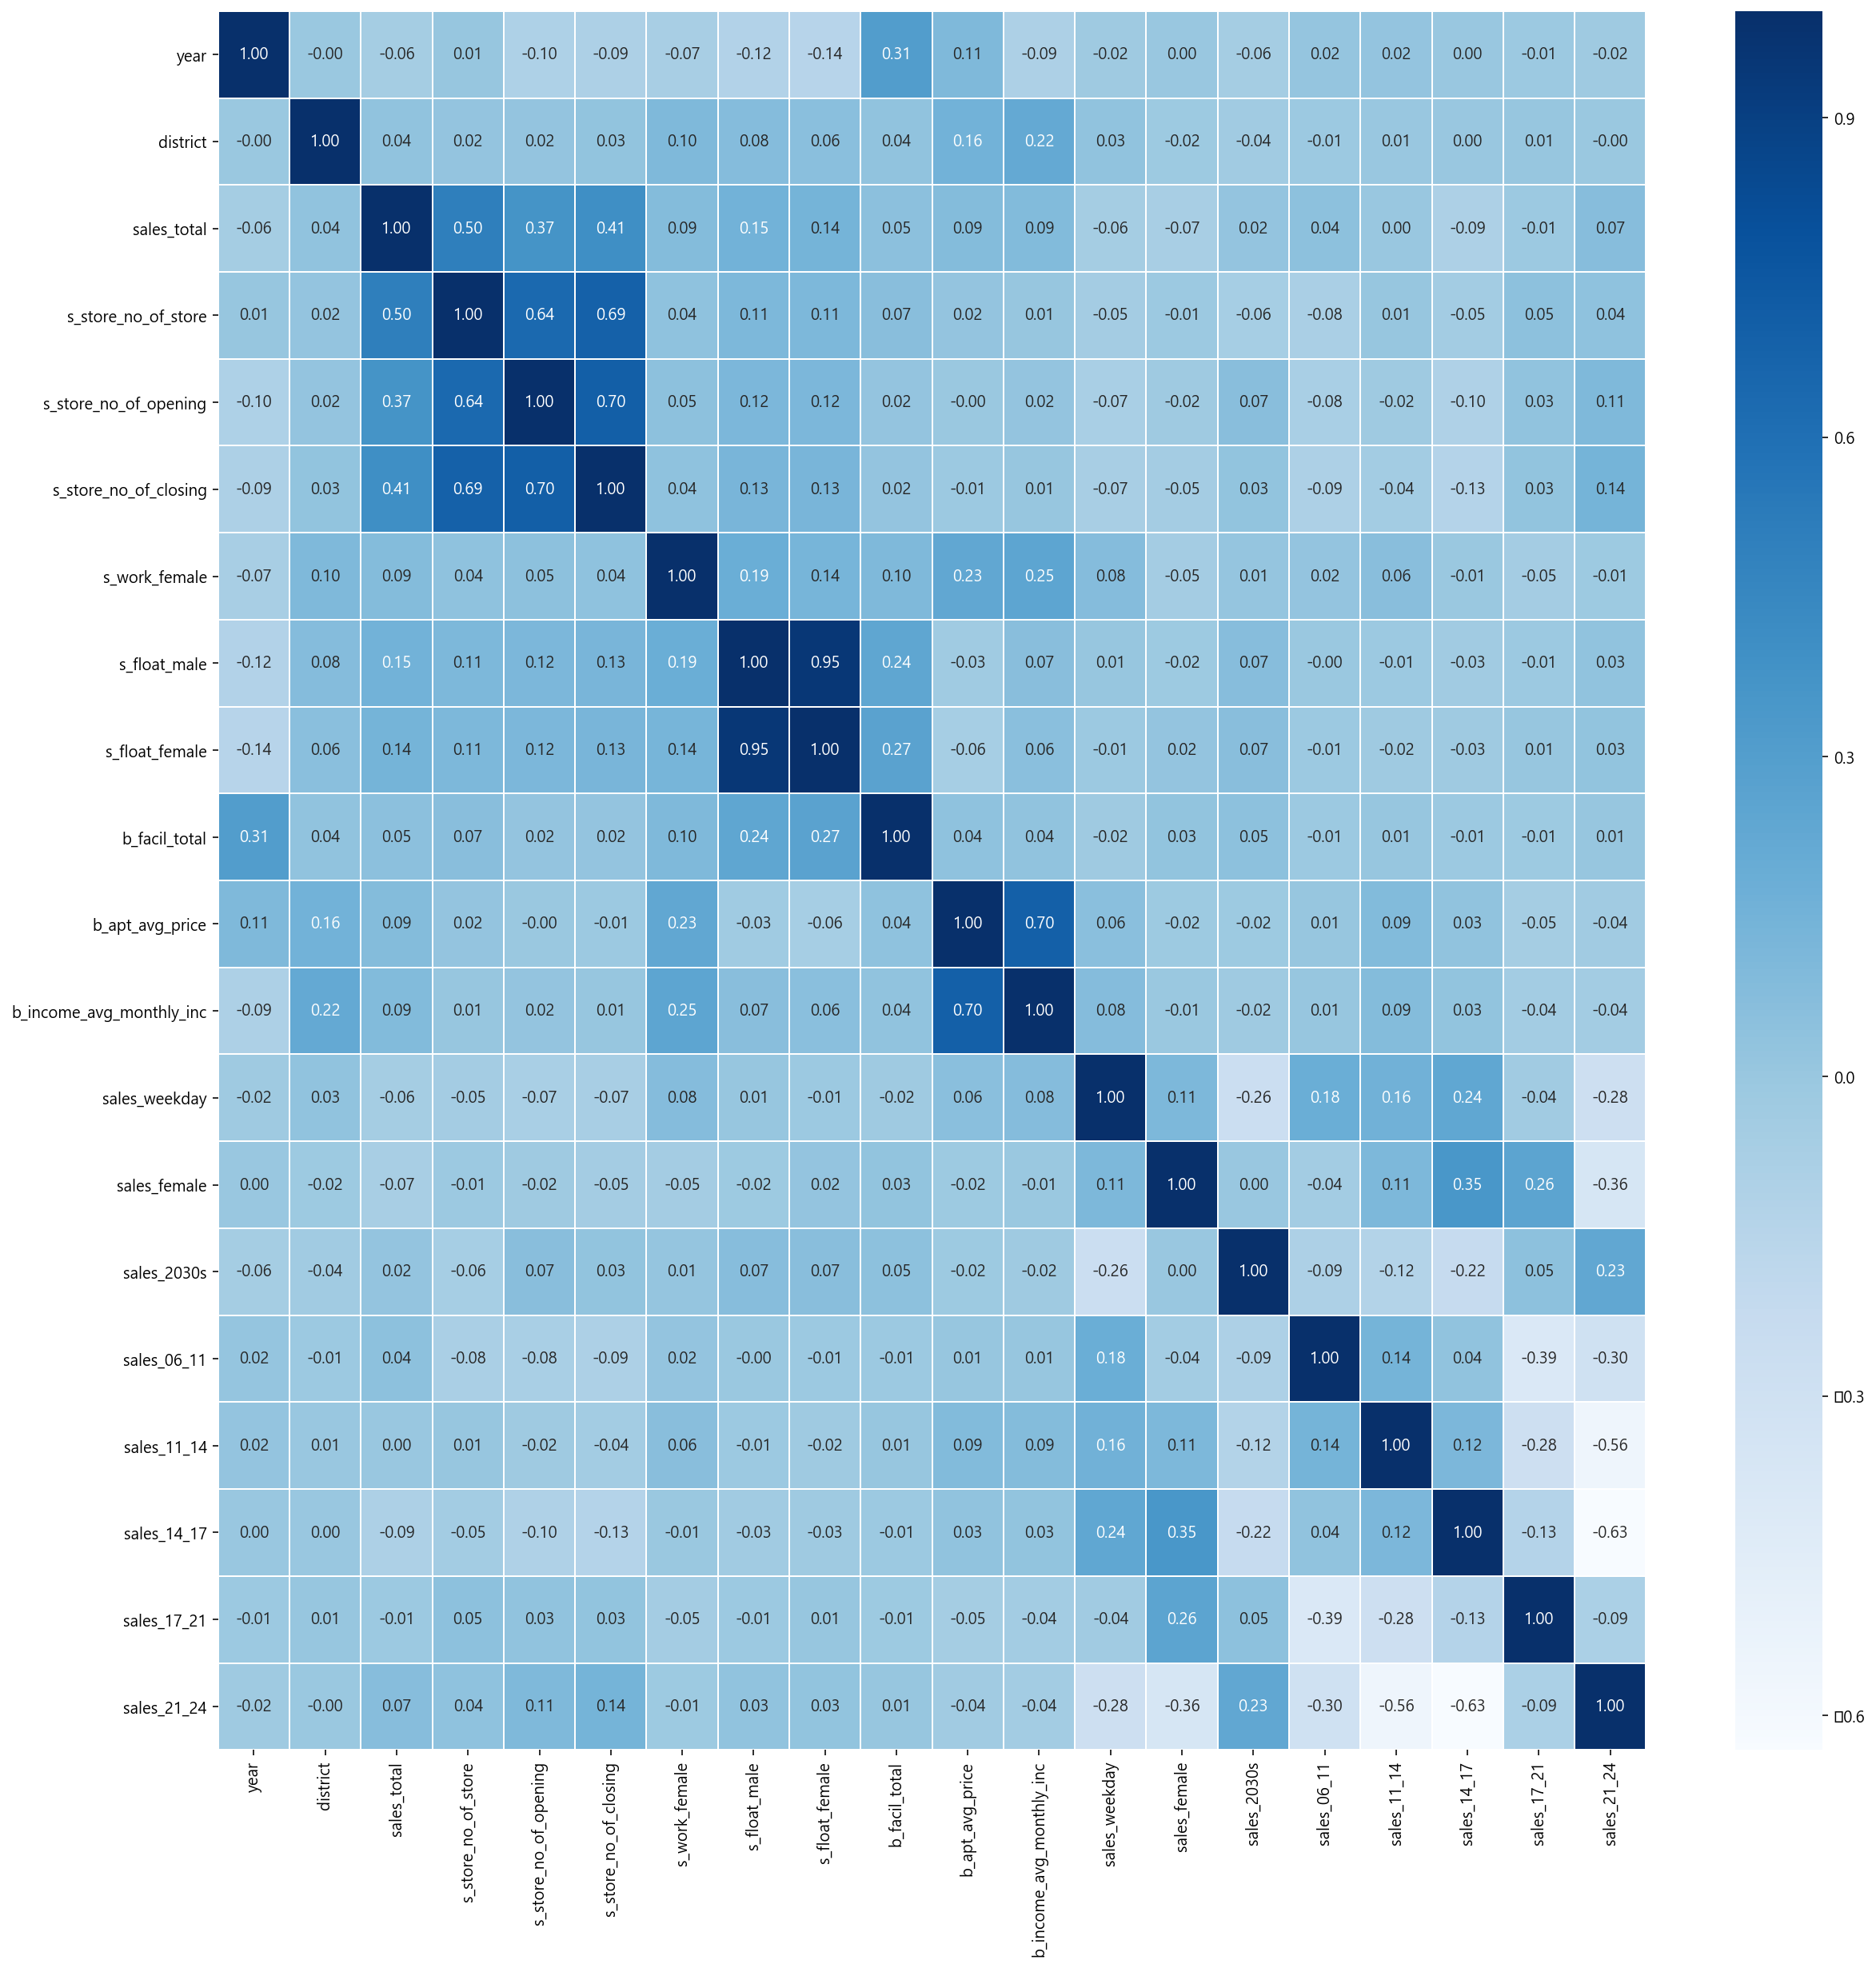

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)


plt.figure(figsize=(20,20))
sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()

### OLS 분석

In [264]:
#로버스트 스케일링
from sklearn.preprocessing import RobustScaler
scale_columns = [i for i in df.columns if i not in ['year', 'district', 'code',]]

rb = RobustScaler()
rb.fit(df[scale_columns])
df_robust_scaled = rb.transform(df[scale_columns])
df_robust_scaled = pd.DataFrame(df_robust_scaled, columns=scale_columns)
df_robust_scaled=pd.concat([df_robust_scaled,df[['code','district']]], axis=1)

model= sm.OLS.from_formula("sales_total ~ "+" + ".join(scale_columns[1:]), data=df_robust_scaled)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            sales_total   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     2800.
Date:                Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:20:07   Log-Likelihood:            -2.3863e+05
No. Observations:              113265   AIC:                         4.773e+05
Df Residuals:                  113247   BIC:                         4.775e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 결과
- R2= 0.442로 낮은편
- 다중공선성 발행
    - 너무 많은 district(상권코드)로 인해 다중공선성 발행한것으로 보임
    - 상권코드를 시군구로 대체하여 카테고리 변수를 줄여보고자 함

### 상권코드를 시군구로 대체

In [1]:
#데이터 가져오기
df = pd.read_csv("raw_data/df_grouped_rate.csv", encoding ='utf-8')
cgoongu = pd.read_csv("raw_data/cgoongoo1.csv", encoding ='utf-8')

In [2]:
df_merged = pd.merge(df, cgoongu, on=['district'])
df_merged.drop(['district'], axis=1, inplace =True)

In [3]:
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

scale_columns = [i for i in df_merged.columns if i not in ['year', 'district', 'code','cgoongoo']]

rb = RobustScaler()
rb.fit(df_merged[scale_columns])
df_robust_scaled = rb.transform(df_merged[scale_columns])
df_robust_scaled = pd.DataFrame(df_robust_scaled, columns=scale_columns)
df_robust_scaled=pd.concat([df_robust_scaled,df_merged[['code','cgoongoo']]], axis=1)


X_columns = [i for i in df_robust_scaled.columns if i not in ['sales_total']]
X= df_robust_scaled[X_columns]
y= df_robust_scaled['sales_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=5)

df_train=pd.concat([y_train, X_train], axis=1)
df_train.columns
model= sm.OLS.from_formula("sales_total ~ C(code)+ C(cgoongoo)+{}+0".format(" + ".join(df_train[df_train.columns[1:-2]])), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            sales_total   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     384.9
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:08:28   Log-Likelihood:                -89899.
No. Observations:               45306   AIC:                         1.800e+05
Df Residuals:                   45220   BIC:                         1.807e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(code)[CS100001]       

In [4]:
### 시군구별로 groupby 해서 OLS

In [5]:
#데이터 가져오기
df = pd.read_csv("raw_data/df_grouped.csv", encoding ='utf-8')
cgoongu = pd.read_csv("raw_data/cgoongoo1.csv", encoding ='utf-8')

In [6]:
df_merged = pd.merge(df, cgoongu, on=['district'])
df_merged.drop(['district'], axis=1, inplace =True)

In [7]:
df_cgoongu_gb = df_merged.groupby(['year','cgoongoo', 'code']).agg({
'sales_total' : 'sum',
's_store_no_of_store' : 'median',
's_store_no_of_opening' : 'sum',
's_store_no_of_closing' : 'sum',
'sales_weekday_amt' : 'sum',
'sales_female_amt' : 'sum',
'sales_2030s_amt' : 'sum',
'sales_06_11_amt' : 'sum',
'sales_11_14_amt' : 'sum',
'sales_14_17_amt' : 'sum',
'sales_17_21_amt' : 'sum',
'sales_21_24_amt' : 'sum',
's_work_female' : 'sum',
's_float_male' : 'sum',
's_float_female' : 'sum',
'b_facil_total' : "median",
'b_apt_avg_price' : 'median',
'b_income_avg_monthly_inc' : 'median',
})

In [8]:
#비율로 바꾸기
df_cgoongu_gb['sales_weekday']= df_cgoongu_gb['sales_weekday_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_female']= df_cgoongu_gb['sales_female_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_2030s']= df_cgoongu_gb['sales_2030s_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_06_11']= df_cgoongu_gb['sales_06_11_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_11_14']= df_cgoongu_gb['sales_11_14_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_14_17']= df_cgoongu_gb['sales_14_17_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_17_21']= df_cgoongu_gb['sales_17_21_amt']/df_cgoongu_gb['sales_total']
df_cgoongu_gb['sales_21_24']= df_cgoongu_gb['sales_21_24_amt']/df_cgoongu_gb['sales_total']


In [9]:
df_cgoongu_gb.drop(columns=['sales_weekday_amt', 'sales_female_amt',
       'sales_2030s_amt', 'sales_06_11_amt', 'sales_11_14_amt',
       'sales_14_17_amt', 'sales_17_21_amt', 'sales_21_24_amt'], inplace=True)

In [181]:
# df 저장
# index에 names=['year', 'cgoongoo', 'code']가 들어있다
df_cgoongu_gb.to_csv('raw_data/df_cgoongu_gb.csv', index=True, encoding='utf-8')

In [10]:
df_cgoongu_gb.columns

Index(['sales_total', 's_store_no_of_store', 's_store_no_of_opening',
       's_store_no_of_closing', 's_work_female', 's_float_male',
       's_float_female', 'b_facil_total', 'b_apt_avg_price',
       'b_income_avg_monthly_inc', 'sales_weekday', 'sales_female',
       'sales_2030s', 'sales_06_11', 'sales_11_14', 'sales_14_17',
       'sales_17_21', 'sales_21_24'],
      dtype='object')

In [11]:
df_cgoongu_gb.reset_index(inplace=True)

In [12]:
df_cgoongu_gb.tail()

,year,cgoongoo,code,sales_total,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_work_female,s_float_male,s_float_female,...,b_apt_avg_price,b_income_avg_monthly_inc,sales_weekday,sales_female,sales_2030s,sales_06_11,sales_11_14,sales_14_17,sales_17_21,sales_21_24
5586,2019,11740,CS300013,1.944441e+09,2.00,0,2,11584,5271020,5113991,...,171075944.0,3352796.50,0.835580,0.526417,0.196412,0.019926,0.373401,0.235047,0.346212,0.025415
5587,2019,11740,CS300014,4.520520e+09,2.75,2,3,15369,7799894,7589784,...,175485945.0,3375250.50,0.645187,0.613730,0.426388,0.064484,0.227725,0.307195,0.376218,0.017544
5588,2019,11740,CS300015,5.912349e+09,4.50,1,1,2868,2289315,2215255,...,166760267.0,3294866.25,0.670696,0.549583,0.300286,0.024988,0.179387,0.368760,0.426864,0.000000
5589,2019,11740,CS300016,5.516874e+09,7.75,8,7,12399,9806328,9570587,...,170942087.0,3340437.75,0.817180,0.289058,0.182388,0.292008,0.195878,0.362834,0.148812,0.000467
5590,2019,11740,CS300017,2.322398e+09,3.50,0,1,3693,2911475,2878879,...,165281764.0,3256684.00,0.547681,0.393481,0.425303,0.042813,0.345796,0.422411,0.187512,0.001467


In [16]:
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

scale_columns = [i for i in df_cgoongu_gb.columns if i not in ['year', 'cgoongoo', 'code',]]

rb = RobustScaler()
rb.fit(df_cgoongu_gb[scale_columns])
df_robust_scaled = rb.transform(df_cgoongu_gb[scale_columns])
df_robust_scaled = pd.DataFrame(df_robust_scaled, columns=scale_columns)
df_robust_scaled=pd.concat([df_robust_scaled,df_cgoongu_gb[['code','cgoongoo']]], axis=1)
df_robust_scaled.columns


X_columns = [i for i in df_robust_scaled.columns if i not in ['sales_total']]
X= df_robust_scaled[X_columns]
y= df_robust_scaled['sales_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=3)

df_train=pd.concat([y_train, X_train], axis=1)
df_train.columns
model= sm.OLS.from_formula("sales_total ~ C(code)+ {}+0".format(" + ".join(df_train[df_train.columns[1:-2]])), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            sales_total   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     225.4
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:09:59   Log-Likelihood:                -2254.0
No. Observations:                2236   AIC:                             4632.
Df Residuals:                    2174   BIC:                             4986.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(code)[CS100001]       

## 결론 
- R2가 높게 나왔다
- log값을 취하는 것이 좋은지 등 분포를 파악하기 위해 부분회귀분석 실시

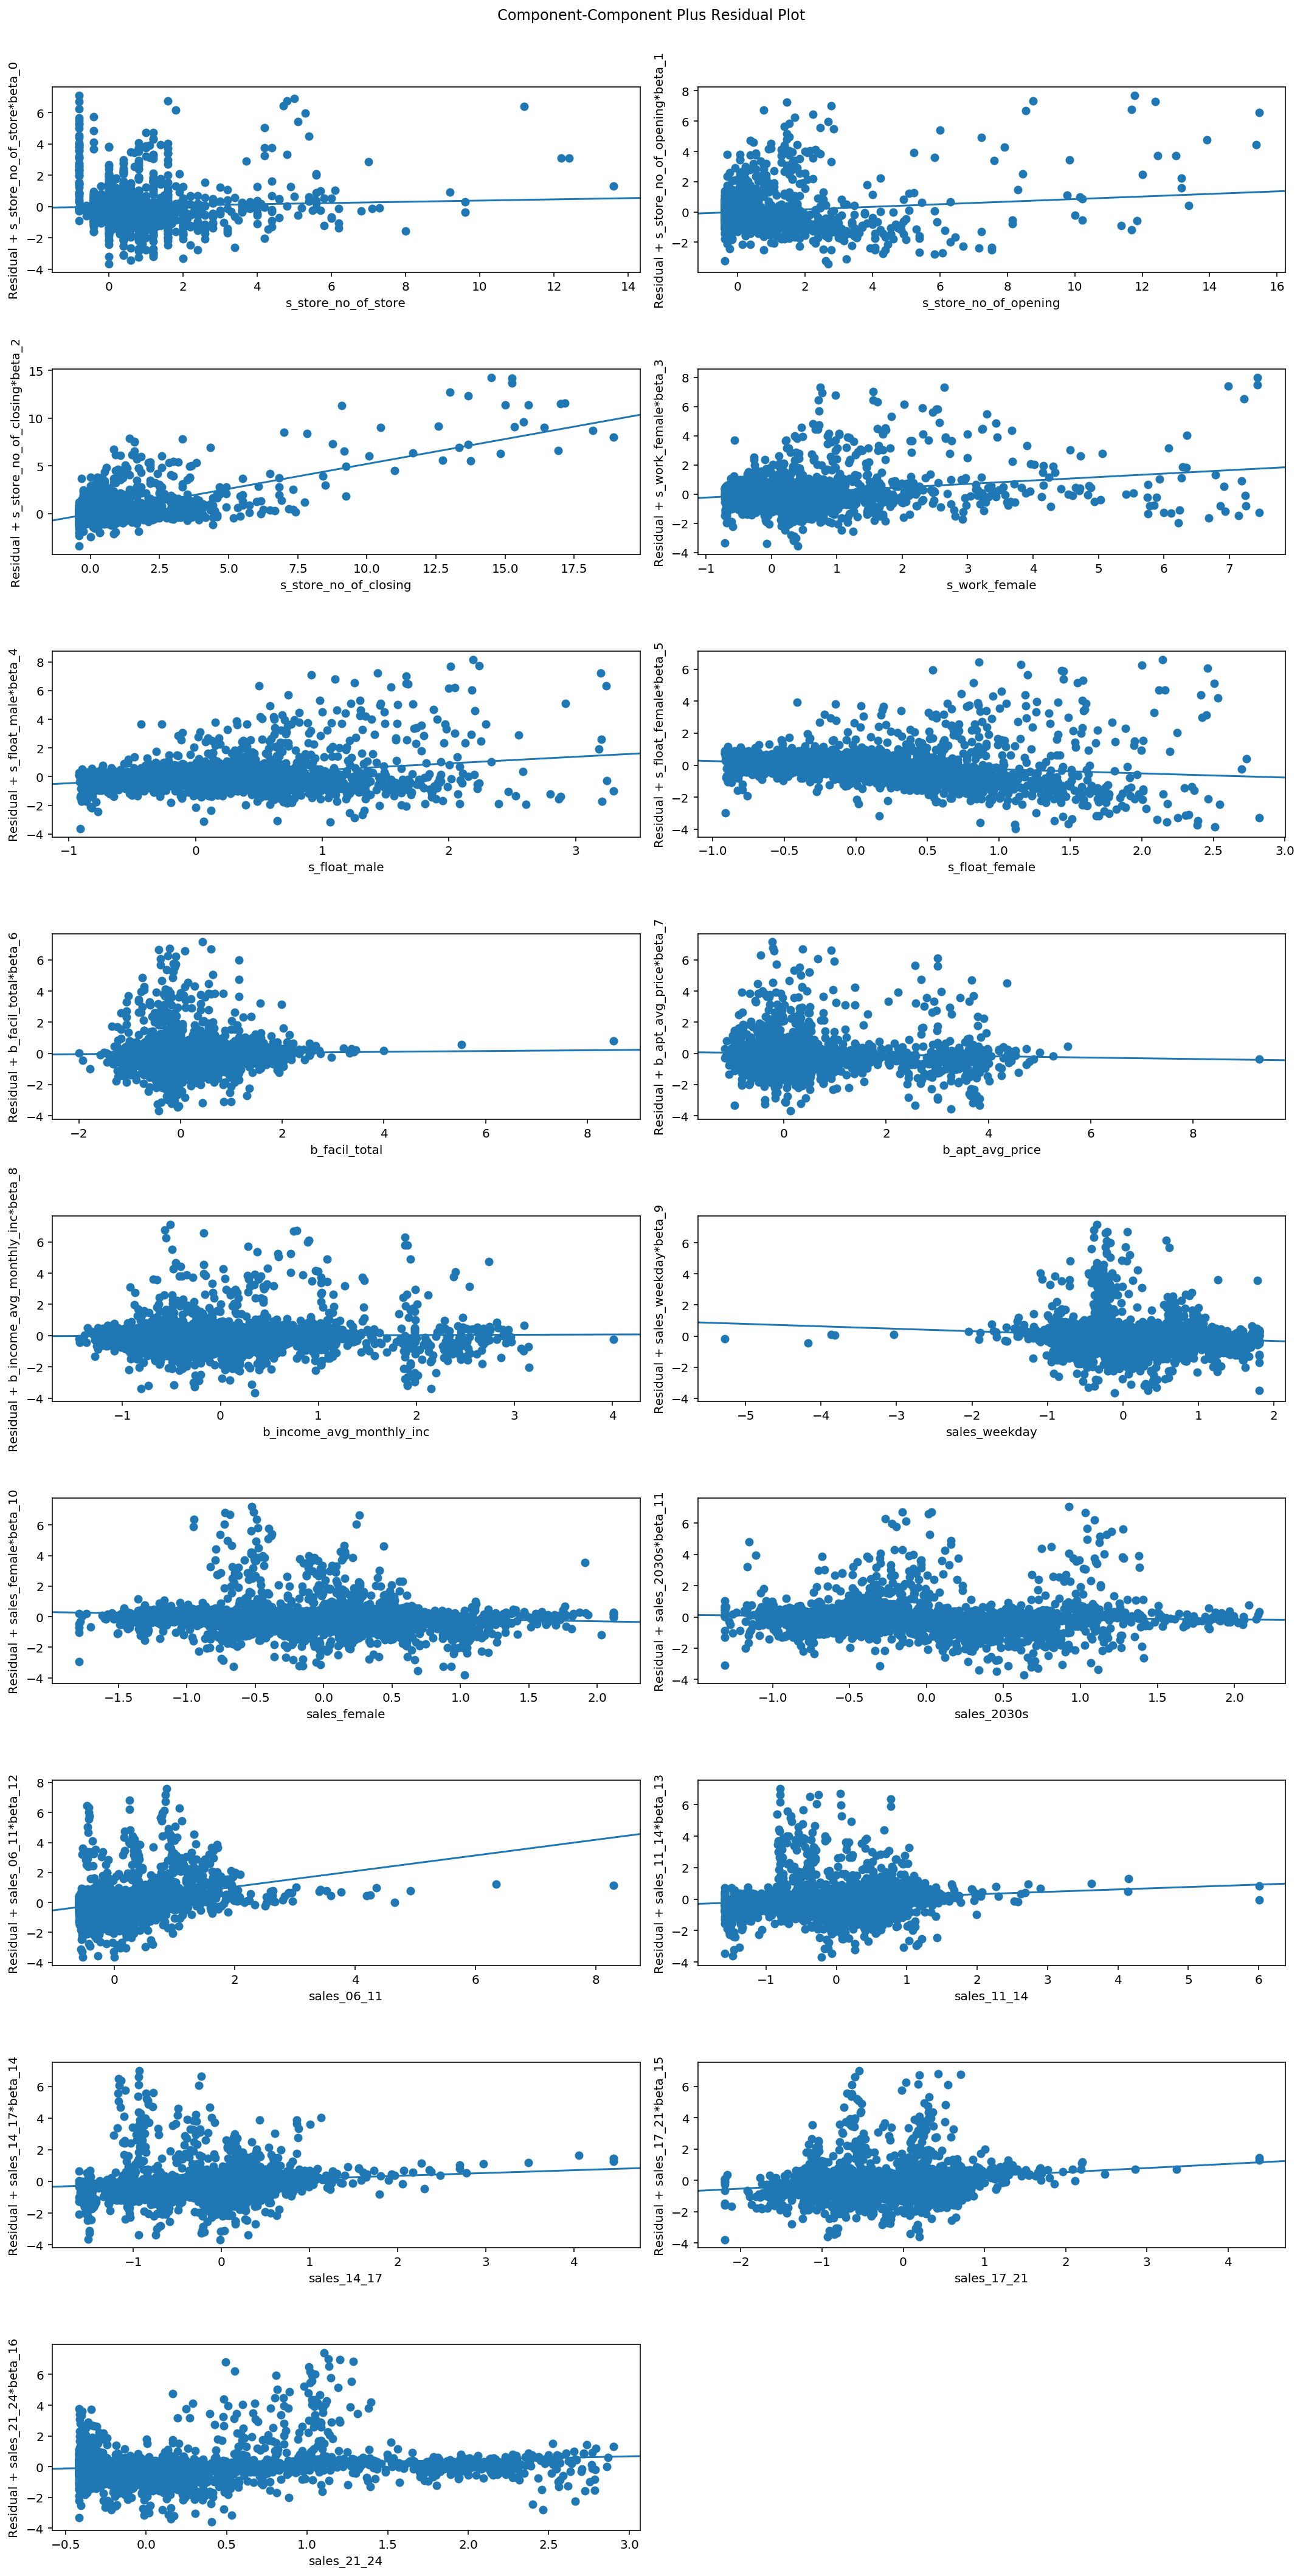

In [17]:
#부분회귀분석 CCPR플롯으로 표현
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
scale_columns = [i for i in df_cgoongu_gb.columns if i not in ['year', 'cgoongoo', 'code',]]

rb = RobustScaler()
rb.fit(df_cgoongu_gb[scale_columns])
df_robust_scaled = rb.transform(df_cgoongu_gb[scale_columns])
df_robust_scaled = pd.DataFrame(df_robust_scaled, columns=scale_columns)
df_robust_scaled=pd.concat([df_robust_scaled,df_cgoongu_gb[['code','cgoongoo']]], axis=1)
# df_robust_scaled.columns


X_columns = [i for i in df_robust_scaled.columns if i not in ['sales_total']]
X= df_robust_scaled[X_columns]
y= df_robust_scaled['sales_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6 )

df_train=pd.concat([y_train, X_train], axis=1)
model= sm.OLS.from_formula("sales_total ~ {}+0".format(" + ".join(df_train[df_train.columns[1:-2]])), data=df_train)
result =  model.fit()
fig = plt.figure(figsize=(15,30))
sm.graphics.plot_ccpr_grid(result, fig=fig)
plt.show()

In [18]:
df_robust_scaled.describe()

,sales_total,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_work_female,s_float_male,s_float_female,b_facil_total,b_apt_avg_price,b_income_avg_monthly_inc,sales_weekday,sales_female,sales_2030s,sales_06_11,sales_11_14,sales_14_17,sales_17_21,sales_21_24,cgoongoo
count,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000,5591.000000
mean,0.567236,0.476677,0.599906,0.671943,0.340140,0.140099,0.133835,0.190155,0.421198,0.141615,0.072918,-0.055890,0.058332,0.183995,-0.034222,-0.140051,-0.109215,0.307237,11417.096226
std,1.740953,1.252014,1.619672,1.898052,1.148599,0.739431,0.719653,0.817598,1.260409,0.852847,0.736118,0.719953,0.676993,0.737140,0.821797,0.697946,0.695956,0.792306,186.370465
min,-0.476250,-0.800000,-0.384615,-0.416667,-0.717924,-0.921770,-0.920472,-2.019802,-1.355924,-1.647372,-5.279512,-1.789344,-1.312530,-1.182522,-1.588602,-1.616296,-2.201261,-0.461817,11110.000000
25%,-0.328005,-0.200000,-0.230769,-0.250000,-0.369114,-0.437339,-0.433806,-0.356436,-0.358821,-0.483524,-0.417121,-0.564669,-0.478056,-0.394151,-0.556376,-0.668286,-0.610506,-0.306229,11260.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11410.000000
75%,0.671995,0.800000,0.769231,0.750000,0.630886,0.562661,0.566194,0.643564,0.641179,0.516476,0.582879,0.435331,0.521944,0.605849,0.443624,0.331714,0.389494,0.693771,11560.000000
max,18.839622,13.600000,15.461538,19.416667,7.915248,3.328042,2.943961,8.514851,10.890900,4.011438,1.802741,2.117967,2.674595,8.290437,6.001995,4.448439,4.380432,3.028611,11740.000000


### 모델 검증하기

In [24]:
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

scale_columns = [i for i in df_cgoongu_gb.columns if i not in ['year', 'cgoongoo', 'code',]]

rb = RobustScaler()
rb.fit(df_cgoongu_gb[scale_columns])
df_robust_scaled = rb.transform(df_cgoongu_gb[scale_columns])
df_robust_scaled = pd.DataFrame(df_robust_scaled, columns=scale_columns)
df_robust_scaled=pd.concat([df_robust_scaled,df_cgoongu_gb[['code','cgoongoo']]], axis=1)
df_robust_scaled.columns


X_columns = [i for i in df_robust_scaled.columns if i not in ['sales_total']]
X= df_robust_scaled[X_columns]
y= df_robust_scaled['sales_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=7 )

df_train=pd.concat([y_train, X_train], axis=1)
df_train.columns
model= sm.OLS.from_formula("sales_total ~ C(code)+ {}+0".format(" + ".join(df_train[df_train.columns[1:-2]])), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            sales_total   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     195.4
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:11:48   Log-Likelihood:                -2183.0
No. Observations:                2236   AIC:                             4490.
Df Residuals:                    2174   BIC:                             4844.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(code)[CS100001]       

```
OLS Regression Results                            
==============================================================================
Dep. Variable:            sales_total   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     251.3
Date:                Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:27:46   Log-Likelihood:                -2224.9
No. Observations:                2236   AIC:                             4574.
Df Residuals:                    2174   BIC:                             4928.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
(code 생략)...
s_store_no_of_store          0.0793      0.026      3.026      0.003       0.028       0.131
s_store_no_of_opening        0.1190      0.029      4.169      0.000       0.063       0.175
s_store_no_of_closing        0.2963      0.026     11.552      0.000       0.246       0.347
s_work_female                0.2477      0.023     10.953      0.000       0.203       0.292
s_float_male                 0.5725      0.136      4.206      0.000       0.306       0.839
s_float_female              -0.2945      0.140     -2.108      0.035      -0.568      -0.020
b_facil_total                0.0118      0.018      0.640      0.523      -0.024       0.048
b_apt_avg_price              0.0167      0.020      0.841      0.400      -0.022       0.056
b_income_avg_monthly_inc    -0.0256      0.031     -0.826      0.409      -0.087       0.035
sales_weekday               -0.0990      0.034     -2.874      0.004      -0.167      -0.031
sales_female                -0.0412      0.045     -0.924      0.356      -0.129       0.046
sales_2030s                  0.0409      0.040      1.014      0.311      -0.038       0.120
sales_06_11                  0.0512      0.064      0.803      0.422      -0.074       0.176
sales_11_14                  0.0917      0.078      1.181      0.238      -0.061       0.244
sales_14_17                  0.0989      0.098      1.009      0.313      -0.093       0.291
sales_17_21                  0.0919      0.088      1.049      0.294      -0.080       0.264
sales_21_24                  0.2105      0.113      1.870      0.062      -0.010       0.431
==============================================================================
Omnibus:                     1004.393   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30917.664
Skew:                           1.497   Prob(JB):                         0.00
Kurtosis:                      20.969   Cond. No.                         97.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
```

In [20]:
df_train.describe()

,sales_total,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_work_female,s_float_male,s_float_female,b_facil_total,b_apt_avg_price,b_income_avg_monthly_inc,sales_weekday,sales_female,sales_2030s,sales_06_11,sales_11_14,sales_14_17,sales_17_21,sales_21_24,cgoongoo
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,0.584945,0.467308,0.599663,0.676170,0.327321,0.137061,0.134018,0.193388,0.401208,0.130730,0.087438,-0.051689,0.047197,0.185585,-0.031751,-0.147439,-0.110859,0.316814,11417.473166
std,1.794798,1.265335,1.638548,1.920667,1.146793,0.742082,0.723883,0.822055,1.281632,0.864285,0.730887,0.715510,0.675009,0.722173,0.836632,0.699830,0.701556,0.805767,183.590858
min,-0.476210,-0.800000,-0.384615,-0.416667,-0.717924,-0.921770,-0.920472,-2.019802,-1.246429,-1.444379,-5.279512,-1.789344,-1.312530,-0.585750,-1.588602,-1.616296,-2.201261,-0.461817,11110.000000
25%,-0.321024,-0.200000,-0.230769,-0.250000,-0.370009,-0.443579,-0.435980,-0.356436,-0.385483,-0.494275,-0.406957,-0.564557,-0.490775,-0.394503,-0.589573,-0.671261,-0.630392,-0.307995,11260.000000
50%,0.004343,0.000000,0.000000,0.000000,-0.024441,-0.004899,-0.008467,-0.009901,-0.027004,-0.040376,0.003674,0.005667,0.002472,0.001903,-0.008346,-0.008779,0.000601,0.015340,11410.000000
75%,0.679991,0.800000,0.692308,0.750000,0.628889,0.554228,0.578996,0.653465,0.580151,0.512976,0.591852,0.433516,0.510009,0.623637,0.459359,0.318064,0.398005,0.686690,11560.000000
max,18.005339,13.600000,15.461538,19.416667,7.915248,3.328042,2.943961,5.742574,10.890900,4.011438,1.802741,2.117967,2.161531,6.345458,6.001995,4.448439,4.380432,3.013678,11740.000000


In [21]:
#오차합 구하기
y_pred = result .predict(X_test)
resid=y_test-y_pred
rss=np.sum(resid**2)
MSE=rss/(result.nobs-2)

#RMSE 구하기
from statsmodels.tools.eval_measures import rmse

rmse = rmse(y_test, y_pred)
MSE, rmse

(0.7025820116002662, 0.6839806809821308)

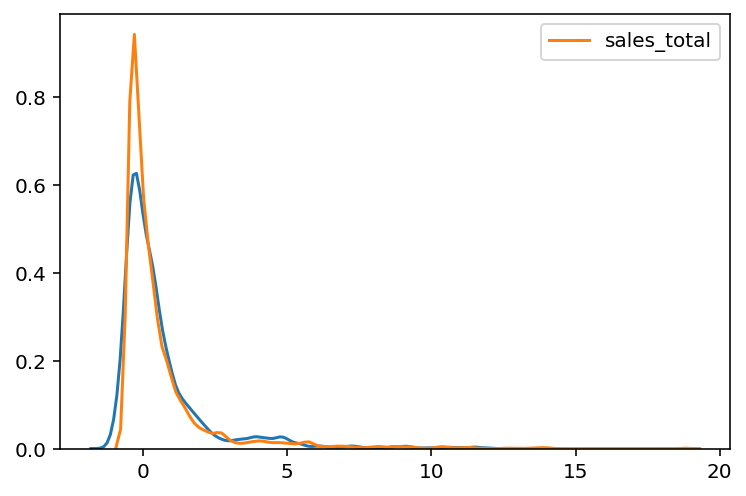

In [22]:
y_pred = result .predict(X_test)
sns.kdeplot(y_pred)
sns.kdeplot(y_test,)
# plt.title("")
plt.show()

In [23]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_robust_scaled)):
    df_train = df_robust_scaled.iloc[idx_train]
    df_test = df_robust_scaled.iloc[idx_test]
    column_x = [i for i in df_train.columns if i not in ['sales_total']]

    model= sm.OLS.from_formula("sales_total ~ C(cgoongoo)+C(code)+ "+" + ".join( df_train[column_x[3:]]), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.sales_total - pred) ** 2).sum()
    tss = ((df_test.sales_total - df_test.sales_total.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.81188366, 검증 R2 = 0.79489238
학습 R2 = 0.81636047, 검증 R2 = 0.76981818
학습 R2 = 0.80338830, 검증 R2 = 0.81647897
학습 R2 = 0.80222677, 검증 R2 = 0.83643349
학습 R2 = 0.81299495, 검증 R2 = 0.78023892


## 의미 도출

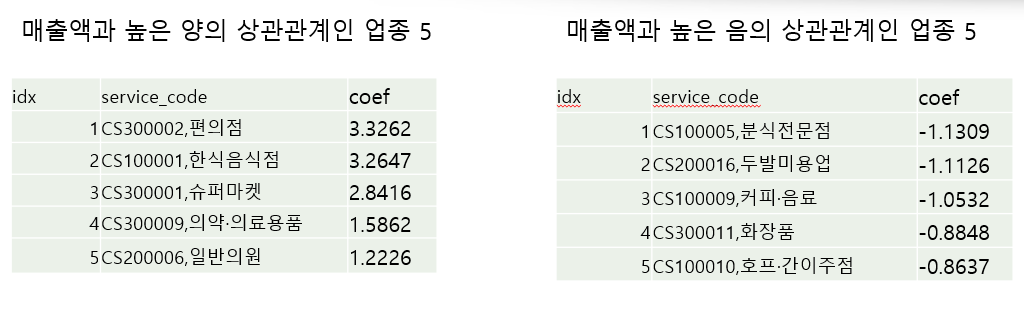

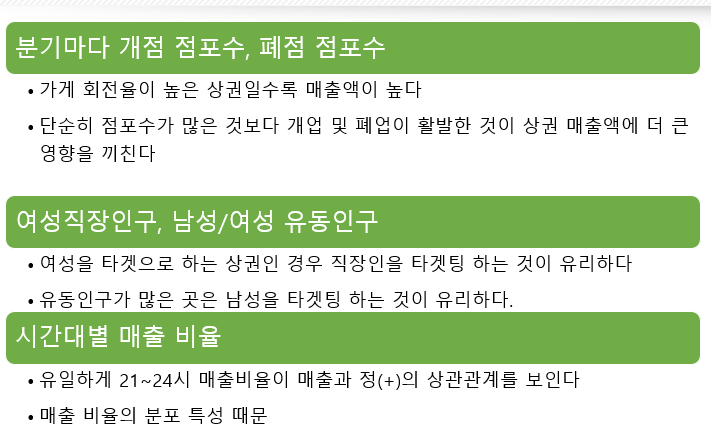

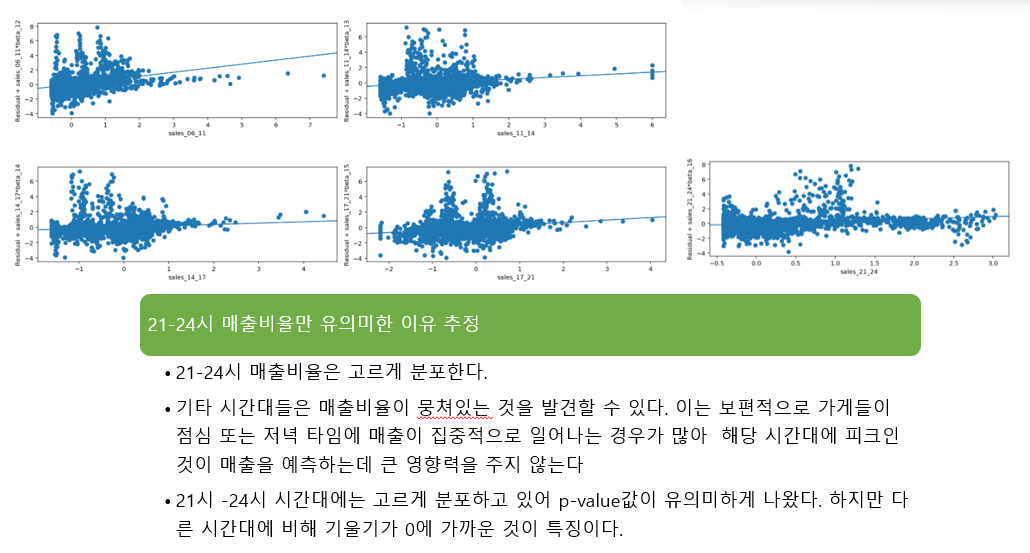